# Structured RerF Demo: Quickdraw Data

We compare the error-counting estimator $\hat{L}_{n,m}$ for $n \in \{10, 20, \dots, 1000\}$ and $m=10000$ over S-RerF, RerF, and a few other classification algorithms. 

In [1]:
%matplotlib inline
import gc
import math
import pandas as pd
import numpy as np
import time, multiprocessing
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import seaborn as sns

from rerf.RerF import fastPredict, fastPredictPost, fastRerF
from rerf.rerfClassifier import rerfClassifier

from scipy.stats import bernoulli
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

gc.enable()

import warnings
warnings.simplefilter('ignore')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
rng = np.random.RandomState(4)

In [3]:
def combine_and_split():
    ## Files downloaded from https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap
    f_fish = "full_numpy_bitmap_fish.npy"    
    f_flamingo = "full_numpy_bitmap_flamingo.npy"    
    f_firetruck = "full_numpy_bitmap_firetruck.npy"    

    fish = np.load(f_fish) 
    flamingo = np.load(f_flamingo) 
    firetruck = np.load(f_firetruck)

    X = np.vstack([fish,flamingo, firetruck])
    y = np.asarray(fish.shape[0]*[0] + flamingo.shape[0]*[1] + firetruck.shape[0]*[2])
    
    return(X,y)

def sort_keep_balance(X,y,block_lengths):
    # Sort data and labels into blocks that preserve class balance
    # X: data matrix
    # y : 1D class labels
    # block_lengths : Block sizes to sort X,y into that preserve class balance
    clss,counts = np.unique(y, return_counts=True)
    ratios = counts / sum(counts)
    class_idxs = [np.where(y==i)[0] for i in clss]

    sort_idxs = []
    
    prior_idxs = np.zeros(len(clss)).astype(int)
    for n in block_lengths:
        get_idxs = np.rint(n*ratios).astype(int)
        for idxs,prior_idx,next_idx in zip(class_idxs,prior_idxs,get_idxs):
            sort_idxs.append(idxs[prior_idx:next_idx])
        prior_idxs = get_idxs
        
    sort_idxs = np.hstack(sort_idxs)
    
    return((X[sort_idxs,:], y[sort_idxs]))

<Figure size 432x288 with 0 Axes>

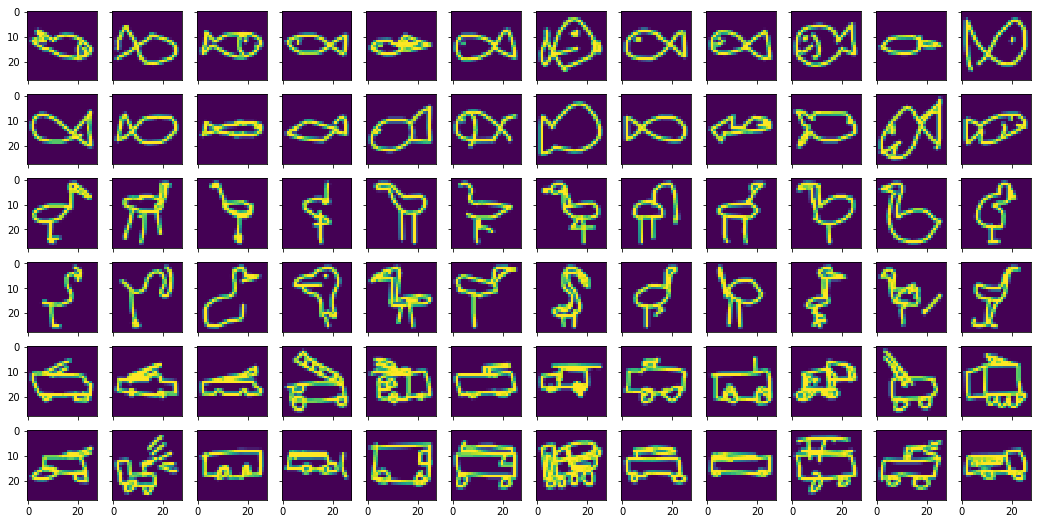

In [61]:
plt.clf()
nrows = 2
fig, axes = plt.subplots(3*nrows,12, figsize = (18,9), sharey=True, sharex=True)

for j,axs in enumerate(axes):
    idx = int(j/nrows)
    for ax,i in zip(axs, np.where(y==idx)[0][j*12:(j+nrows)*12]):
        ax.imshow(np.reshape(X[i], (28, 28)))

In [22]:
X,y = combine_and_split()

#ns = np.linspace(2,np.log10(len(y)),7)
#ns = np.power(10,ns).astype(int)
ns = [10,100,1000,5000,10000]

In [23]:
X,y = sort_keep_balance(X,y,ns)

In [30]:
## Setup for run, define classifiers to train and test
names = {"Log. Reg": "#a6cee3", 
         "Lin. SVM":"#1f78b4", 
         "SVM":"#b2df8a", 
         "kNN": "#33a02c", 
         "RF":"#fb9a99", 
         "MLP":"#fdbf6f", 
         "SporF":"#ff7f00", 
         "MF":"#e31a1c"}
         #"CNN":"#cab2d6"}

ncores=1
num_runs=1
n_est=100
mx = 6
mn = 1

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=500),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
        max_features = 28, n_jobs = ncores),
    rerfClassifier(
        projection_matrix="S-RerF", 
        max_features = 28,
        n_estimators=n_est,
        n_jobs=ncores,
        image_height=28, 
        image_width=28, 
        patch_height_max=mx,
        patch_width_max=mn,
        patch_height_min=mx,
        patch_width_min=mn,
        )
    ]

In [33]:
# iterate
## Prep output file:

write_path = 'mf_quickdraw_all_algo.csv'

with open(write_path, 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")

runList = [(n, clf, iterate) for n in ns[:-1]\
                             for clf in zip(classifiers, [key for key in names])\
                             for iterate in range(1, num_runs + 1)]

k=None

for n, clf, iterate in tqdm(runList):
    #print(f"iterate: {iterate}\t n: {n}\t classifier: {clf[1]}")
    gc.collect()
    if not k is None:
        Xn = X[0:n, ::]
        yn = y[0:n]

        # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, 
        # StratifiedKFold is used. In all other cases, KFold is used.
        cv_results = cross_validate(clf[0], Xn, yn, cv=3, return_train_score=True)


        ####("variable,Lhat,trainTime,testTime,iterate")
        with open(write_path, 'a') as f:
            for kfold, (trainTime, testTime, lhat) in enumerate(
                                             zip(cv_results['fit_time'], 
                                                 cv_results['score_time'], 
                                                 cv_results['test_score'])):
                f.write(f"{clf[1]}, {int(n*(1-1/k))}, {1-lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {kfold+1}\n")
        
    else:
        trainStartTime = time.time()
        clf[0].fit(X[:n,:], y[:n])
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X[5000:,:])
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, y[5000:]).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        with open(write_path, 'a') as f:
            f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")
            
    gc.collect()

 85%|████████▌ | 34/40 [10:07<07:46, 77.74s/it] 

KeyboardInterrupt: 

In [34]:
dat = pd.read_csv(write_path)
dat = dat[dat['n'] < 10**4]

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])

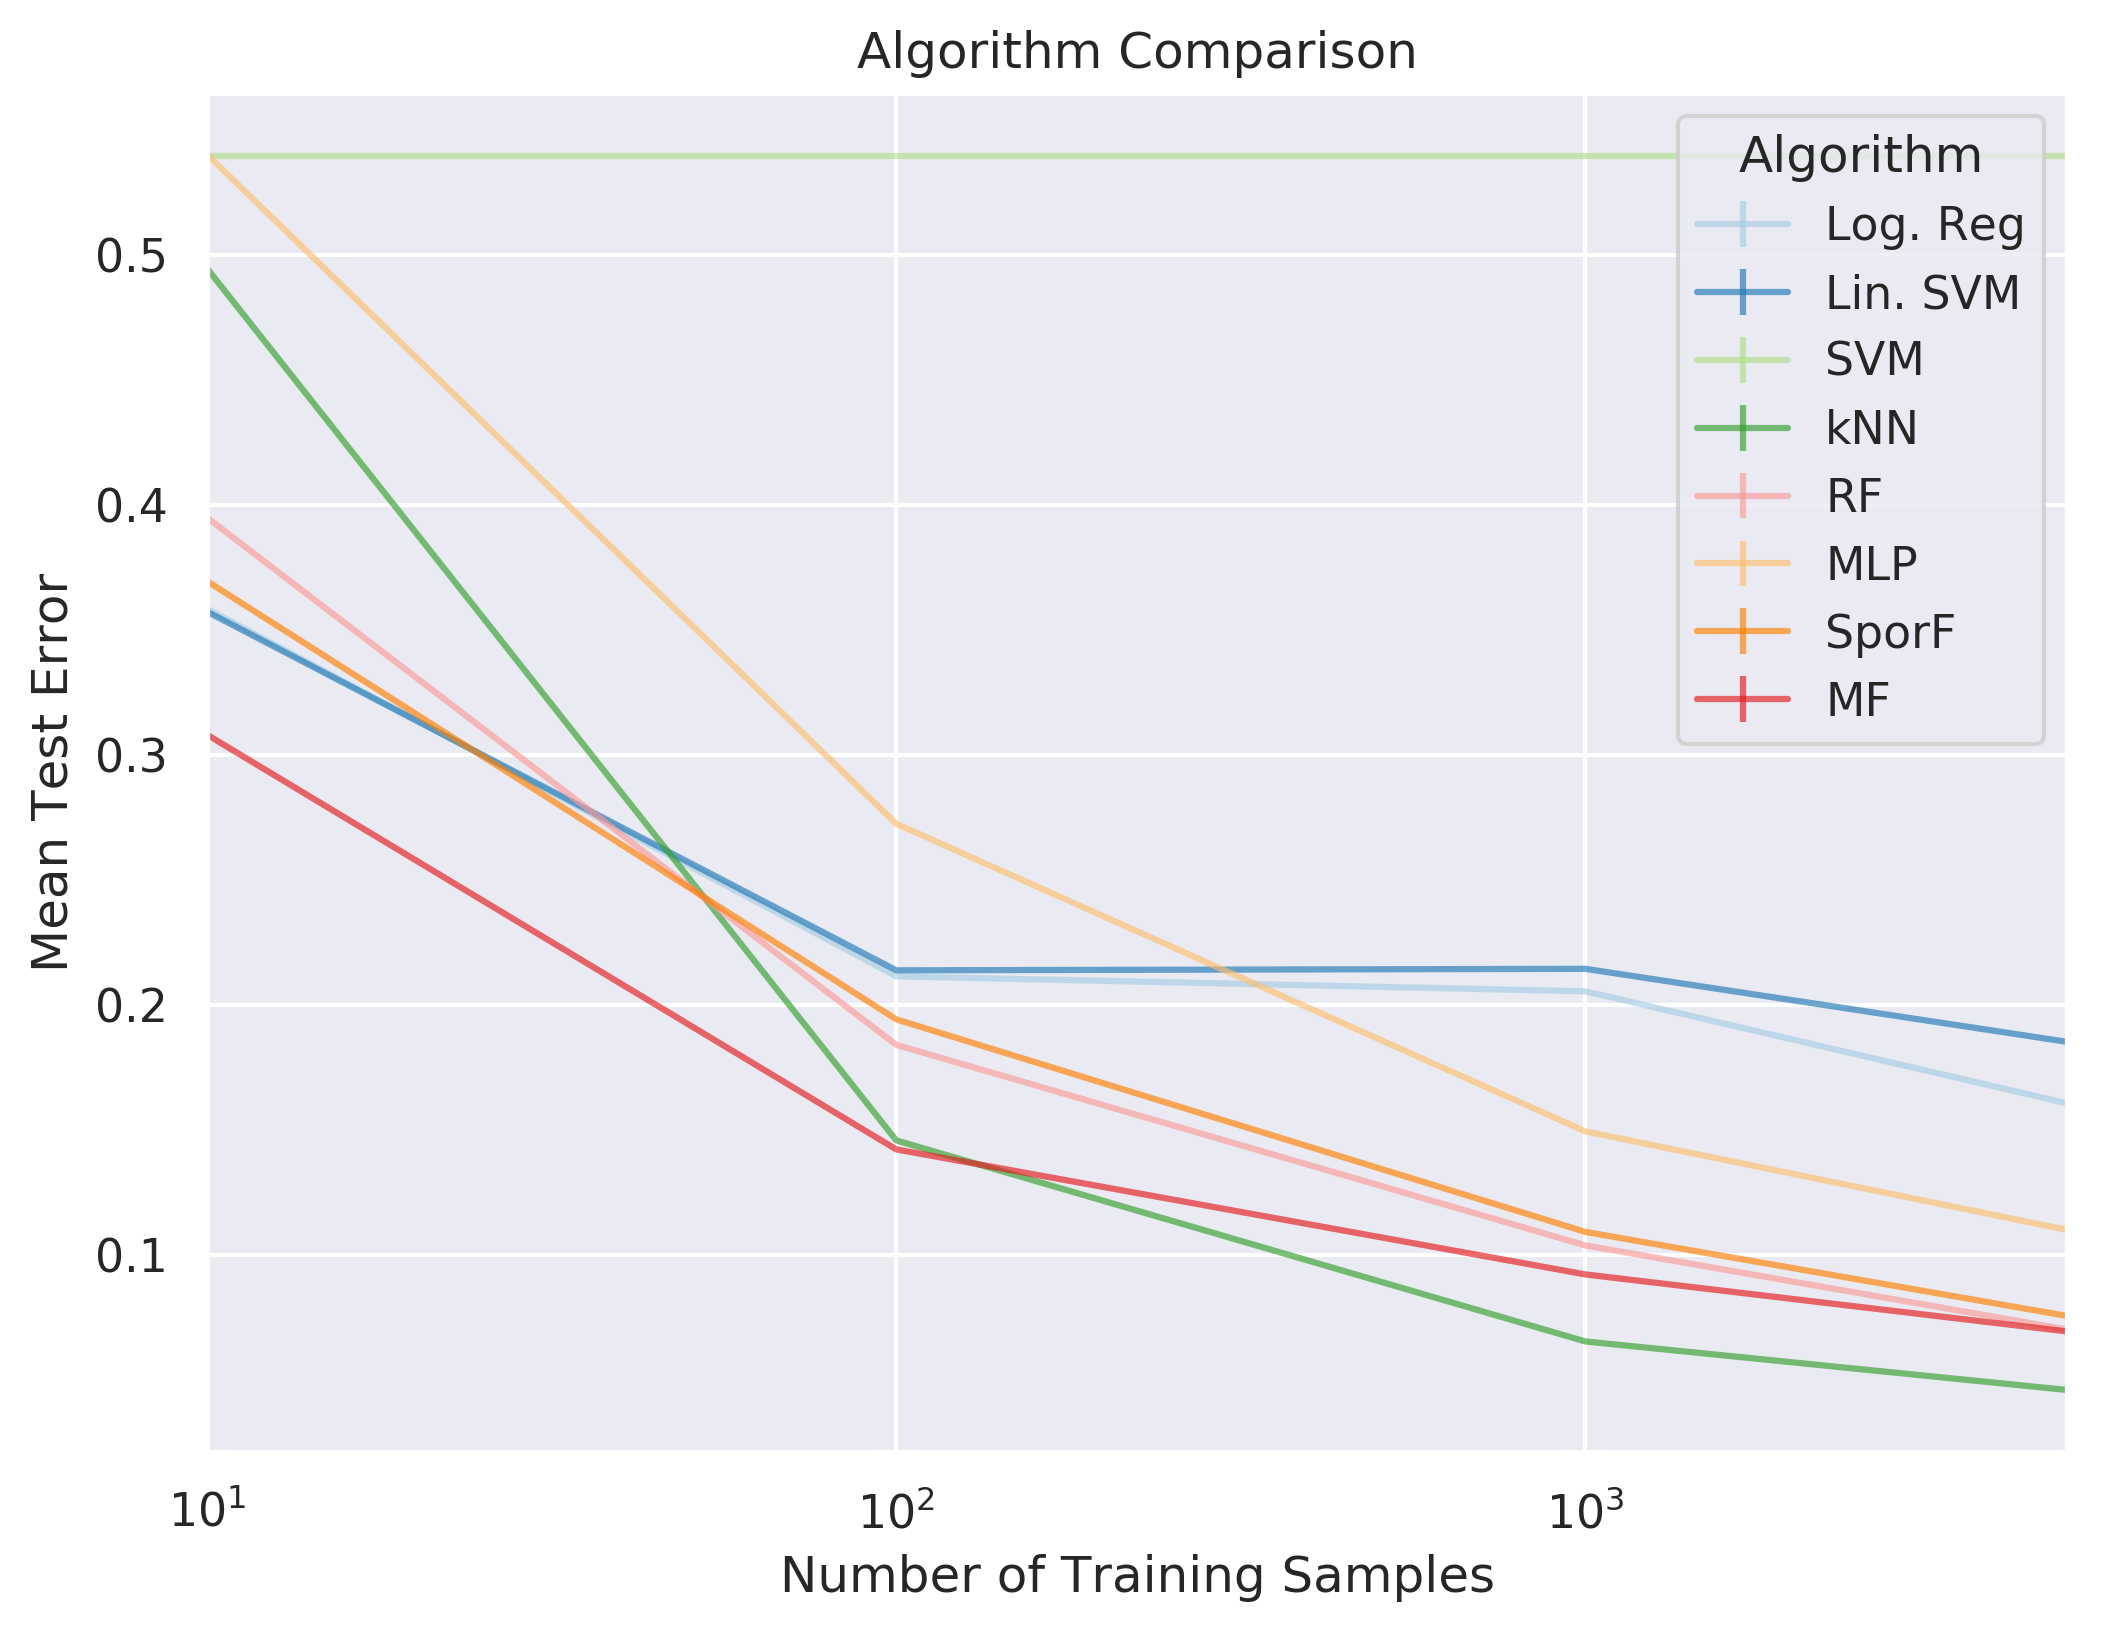

In [35]:
## Plot

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], yerr='se', alpha =0.65)
    ax.set_xscale('log')

plt.legend(loc='upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig(sim_dir / 'quickdraw_experiment.pdf',dpi=300,format='pdf')
plt.show()